In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset,concatenate_datasets
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def filter_data(data, metric_name, metric_value):    
    if metric_name == 'degree':
        p_in_train = data.filter(lambda x: ((x['label']==1) & (x['min_angle']<=metric_value)))
        p_not_in_train = data.filter(lambda x: ((x['label']==1) & (x['min_angle']>metric_value)))        
        n_in_train = data.filter(lambda x: ((x['label']==0) & (x['min_angle']>metric_value)))
        n_not_in_train = data.filter(lambda x: ((x['label']==0) & (x['min_angle']<=metric_value)))
        in_train=concatenate_datasets([p_in_train,n_in_train])
        not_in_train=concatenate_datasets([p_not_in_train,n_not_in_train])        
    elif metric_name == 'distance':
        p_in_train = data.filter(lambda x: ((x['label']==1) & (x['euc_dist']>=metric_value)))
        p_not_in_train = data.filter(lambda x: ((x['label']==1) & (x['euc_dist']<metric_value)))        
        n_in_train = data.filter(lambda x: ((x['label']==0) & (x['euc_dist']<metric_value)))
        n_not_in_train = data.filter(lambda x: ((x['label']==0) & (x['euc_dist']>=metric_value)))        
        in_train=concatenate_datasets([p_in_train,n_in_train])
        not_in_train=concatenate_datasets([p_not_in_train,n_not_in_train])    
    return in_train, not_in_train

In [3]:
def metric_calculation(data):
    gt=data['label']
    pred=data['pred']
    acc=accuracy_score(gt, pred)
    _,fpc,fnc,_=confusion_matrix(gt, pred).ravel()
    fpr=fpc/len(data)
    fnr=fnc/len(data)
    return acc,fpr,fnr

In [4]:
def post_processing(data, model, metric_name, metric_value):
    
    ## load ground truth & predictions
    gt=np.array(data['label'])
    if model == 'heuristic':
        if metric_name=='degree':
            pred=np.array(data['min_angle'])<=metric_value
        elif metric_name == 'distance':
            pred=np.array(data['euc_dist'])>=metric_value
    else:
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}.npy')
        pred=np.array([int(i.replace('<|eot_id|>', '')\
                           .replace('</s>', '')\
                           .split('Label:')[1]\
                           .strip()) for i in pred])
    new_data=data.add_column("pred", pred)
    in_train, not_in_train=filter_data(new_data, metric_name, metric_value)
    
    ## accuracy calculation
    acc,fpr,fnr=metric_calculation(new_data)
    p_acc,_,_=metric_calculation(in_train)
    n_acc,_,_=metric_calculation(not_in_train)
    
    return pred,acc,fpr,fnr,p_acc,n_acc

In [5]:
ds = load_dataset("beanham/spatial_join_dataset")
test=ds['test']
models=['heuristic','llama3','mistral']
metric_names=['degree', 'distance']
predictions={}
results=[]
for model in models:
    for metric_name in metric_names:
        if metric_name=='degree':
            metric_values=[1,2,5,10,20]
        elif metric_name=='distance':
            metric_values=[1,2,3,4,5]        
        for metric_value in metric_values:
            pred,acc,fpr,fnr,p_acc,n_acc=post_processing(test, model,metric_name,metric_value)
            results.append([model, metric_name, metric_value, acc,fpr,fnr,p_acc,n_acc])
            predictions[f'{model}_{metric_name}_{metric_value}']=pred
results=pd.DataFrame(results, columns=['model','metric','metric_value','acc','fpr','fnr','p_acc','n_acc'])
results['metric_index']=[f'metric_{i}'for i in range(1,6)]*6
degree_results=results[results['metric']=='degree'].reset_index(drop=True)
distance_results=results[results['metric']=='distance'].reset_index(drop=True)

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3069 [00:00<?, ? examples/s]

## Visualization

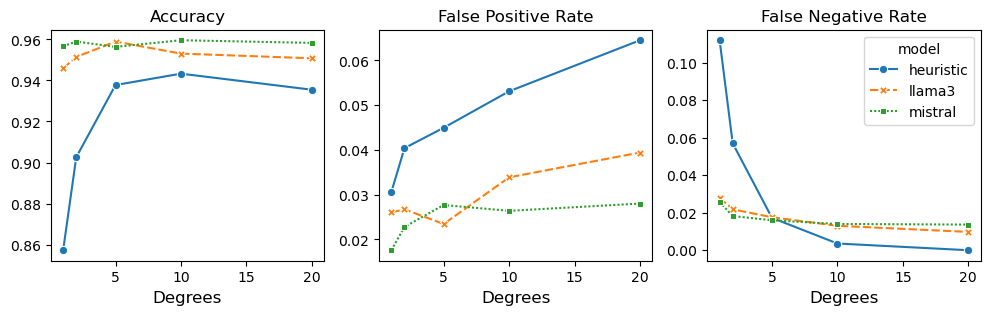

In [52]:
fig, axs = plt.subplots(ncols=3,figsize=(12, 3))
sns.lineplot(data=degree_results, x="metric_value", y="acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=degree_results, x="metric_value", y="fpr",style="model",hue="model",markers=True,ax=axs[1],legend=False)
sns.lineplot(data=degree_results, x="metric_value", y="fnr",style="model",hue="model",markers=True,ax=axs[2])
axs[0].set_xlabel('Degrees', fontsize=12)
axs[1].set_xlabel('Degrees', fontsize=12)
axs[2].set_xlabel('Degrees', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('Accuracy', fontsize=12)
axs[1].set_title('False Positive Rate', fontsize=12)
axs[2].set_title('False Negative Rate', fontsize=12)
#plt.xlabel('Degrees', fontsize=16)
#plt.ylabel('Accuracy', fontsize=16)
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=12)
pass

Overall, we see that:
- Heuristics are value sensitive. A small change used in the heuristic method could lead to 4% change in accuracy. And in reality, it is hard to determine which threshold to use without domain knowledge. Even with domain knowledge, it is hard to determine which value to use given the sensitivity of heuristic method. The best heuristic gives about 0.94 accuracy, which is good.
- Llama3 and Mistral results maintain relatively constant, and higher accuracy than heuristic performance, despite the change in the fine-tuning data. It shows that LLMs are more robust and stable to the change in the data.


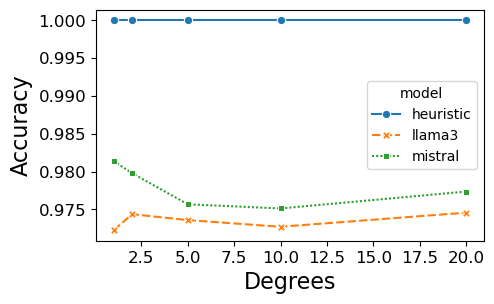

In [11]:
plt.figure(figsize=(5,3))
sns.lineplot(data=degree_results, x="metric_value", y="p_acc",style="model",hue="model",markers=True)
plt.xlabel('Degrees', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
pass

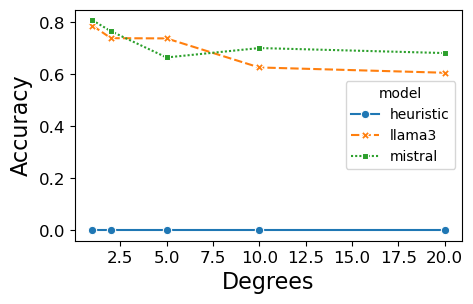

In [12]:
plt.figure(figsize=(5,3))
sns.lineplot(data=degree_results, x="metric_value", y="n_acc",style="model",hue="model",markers=True)
plt.xlabel('Degrees', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
pass

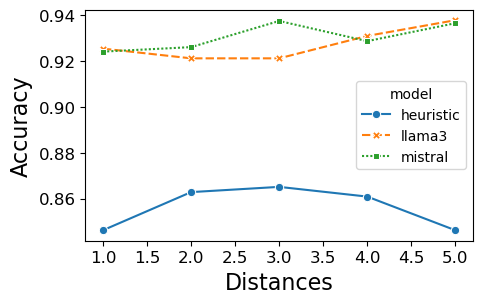

In [142]:
plt.figure(figsize=(5,3))
sns.lineplot(data=distance_results, x="metric_value", y="acc",style="model",hue="model",markers=True)
plt.xlabel('Distances', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
pass

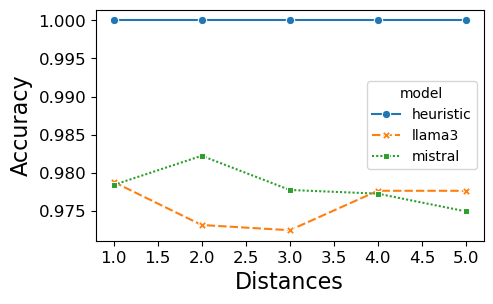

In [13]:
plt.figure(figsize=(5,3))
sns.lineplot(data=distance_results, x="metric_value", y="p_acc",style="model",hue="model",markers=True)
plt.xlabel('Distances', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
pass

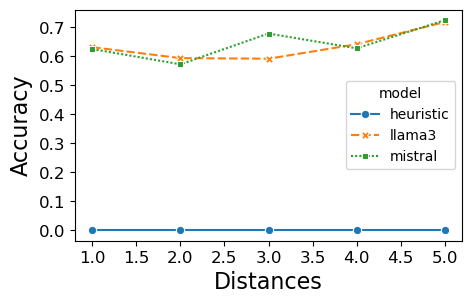

In [14]:
plt.figure(figsize=(5,3))
sns.lineplot(data=distance_results, x="metric_value", y="n_acc",style="model",hue="model",markers=True)
plt.xlabel('Distances', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
pass

## Error Analysis

In [176]:
model, metric_name, metric_value

('mistral', 'distance', 5)

In [185]:
data=test

In [186]:
gt=np.array(data['label'])
if model == 'heuristic':
    if metric_name=='degree':
        pred=np.array(data['min_angle'])<=metric_value
    elif metric_name == 'distance':
        pred=np.array(data['euc_dist'])>=metric_value
else:
    pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}.npy')
    pred=np.array([int(i.replace('<|eot_id|>', '')\
                       .replace('</s>', '')\
                       .split('Label:')[1]\
                       .strip()) for i in pred])
## accuracy calculation
accuracy=accuracy_score(gt, pred)
_,fpc,fnc,_=confusion_matrix(gt, pred).ravel()
fpr=fpc/len(data)
fnr=fnc/len(data)

In [189]:
new_data=data.add_column("pred", pred)
positive, negative=filter_data(new_data, metric_name, metric_value)

In [192]:
positive, negative

(Dataset({
     features: ['sidewalk', 'road', 'min_angle', 'hausdorff_dist', 'euc_dist', 'max_area', 'label', 'pred'],
     num_rows: 1754
 }),
 Dataset({
     features: ['sidewalk', 'road', 'min_angle', 'hausdorff_dist', 'euc_dist', 'max_area', 'label', 'pred'],
     num_rows: 843
 }))

In [182]:
new_test = ds['test'].add_column("pred", pred)
positive, negative=filter_data(new_test, metric_name, metric_value)

In [144]:
ds = load_dataset("beanham/spatial_join_dataset")
test=ds['test']
models=['heuristic','llama3','mistral']
metric_names=['degree', 'distance']
predictions={}
results=[]
for model in models:
    for metric_name in metric_names:
        if metric_name=='degree':
            metric_values=[1,2,5,10,20]
        elif metric_name=='distance':
            metric_values=[1,2,3,4,5]
            
        for metric_value in metric_values:
            pred,acc,fpr,fnr=post_processing(test, model,metric_name,metric_value)

            ## error analysis
            new_test = ds['test'].add_column("pred", pred)
            positive = new_test.filter(lambda x: ((x['label']==1) & (x['min_angle']<=metric_value)))
            negative = new_test.filter(lambda x: ((x['label']==0) & (x['min_angle']>metric_value)))

            ## save results
            results.append([model, metric_name, metric_value, acc, fpr, fnr])
            predictions[f'{model}_{metric_name}_{metric_value}']=pred            

results=pd.DataFrame(results, columns=['model','metric','metric_value','acc','fpr','fnr'])
results['metric_index']=[f'metric_{i}'for i in range(1,6)]*6
degree_results=results[results['metric']=='degree'].reset_index(drop=True)
distance_results=results[results['metric']=='distance'].reset_index(drop=True)

Dataset({
    features: ['sidewalk', 'road', 'min_angle', 'hausdorff_dist', 'euc_dist', 'max_area', 'label'],
    num_rows: 3069
})

In [162]:
new_test = ds['test'].add_column("pred", pred)

In [163]:
new_test

Dataset({
    features: ['sidewalk', 'road', 'min_angle', 'hausdorff_dist', 'euc_dist', 'max_area', 'label', 'pred'],
    num_rows: 3069
})